# Preprocesamiento

### Importación módulos

In [2]:
!pip install geopandas
!pip install chart_studio
!pip install plotly

In [3]:
!pip install folium

In [4]:
!pip install cufflinks

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.express as px



In [6]:
'''#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud'''

'#text mining\nfrom nltk.tokenize import word_tokenize\nfrom nltk.corpus import stopwords\nimport re\nfrom sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer\nfrom wordcloud import WordCloud'

In [7]:
listings = pd.read_csv("data/listings.csv", index_col= "id")

listings_details = pd.read_csv("data/listings_details.csv.gz",  compression='gzip',index_col= "id", low_memory=False)


In [8]:
print(listings.shape)
print(listings_details.shape)

(42451, 17)
(42451, 74)


Listings tiene 17 variables y listings_details 74

In [9]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [10]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

In [11]:
# Me quedaré con las columnas que me parezcan más interesantes:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()


KeyError: "['street', 'weekly_price', 'monthly_price', 'market'] not in index"

# Predicción de precios con listings_details:

https://www.kaggle.com/code/elisabravo/airbnb-price-prediction/edit

### Librerias:

In [12]:
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import re

In [13]:
df = listings_details.copy()

### Estado inicial prelimpieza:

#### Qué tenemos:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42451 entries, 777451666060243581 to 625415450215801684
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   42451 non-null  object 
 1   scrape_id                                     42451 non-null  int64  
 2   last_scraped                                  42451 non-null  object 
 3   source                                        42451 non-null  object 
 4   name                                          42449 non-null  object 
 5   description                                   41701 non-null  object 
 6   neighborhood_overview                         24957 non-null  object 
 7   picture_url                                   42451 non-null  object 
 8   host_id                                       42451 non-null  int64  
 9   host_url                            

Vamos a ver si las variables numericas nos las sabe identificar y calcular. Vemos que algunas de ellas como los id no deberian de ser numeros sino categoricas:

In [15]:
listings_details.describe()

,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4.245100e+04,4.245100e+04,42449.000000,42449.000000,42451.000000,42451.000000,42451.000000,0.0,38832.000000,41854.000000,...,30533.000000,30526.000000,30532.000000,30524.000000,30522.000000,42451.000000,42451.000000,42451.000000,42451.000000,30780.000000
mean,2.023031e+13,1.634216e+08,142.159085,169.611251,34.058002,-118.319520,3.908224,NaN,1.775366,2.160486,...,4.710862,4.839167,4.829212,4.788386,4.673745,56.508092,20.247650,36.067914,0.161480,1.442880
std,0.000000e+00,1.593238e+08,653.655431,760.320411,0.136723,0.171488,2.731220,NaN,1.182934,1.595014,...,0.495622,0.414862,0.435060,0.405893,0.498480,191.566139,93.453999,171.220843,1.787155,1.801396
min,2.023031e+13,5.210000e+02,0.000000,0.000000,33.338480,-118.934830,0.000000,NaN,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.023031e+13,2.430378e+07,1.000000,2.000000,34.000925,-118.432010,2.000000,NaN,1.000000,1.000000,...,4.650000,4.860000,4.840000,4.750000,4.600000,1.000000,1.000000,0.000000,0.000000,0.230000
50%,2.023031e+13,1.074344e+08,3.000000,5.000000,34.064243,-118.347517,3.000000,NaN,1.000000,2.000000,...,4.870000,4.970000,4.970000,4.910000,4.800000,2.000000,1.000000,0.000000,0.000000,0.770000
75%,2.023031e+13,2.735477e+08,15.000000,24.000000,34.118700,-118.247860,5.000000,NaN,2.000000,3.000000,...,5.000000,5.000000,5.000000,5.000000,4.970000,11.000000,5.000000,1.000000,0.000000,2.130000
max,2.023031e+13,5.039739e+08,4784.000000,8316.000000,34.811130,-117.653400,16.000000,NaN,24.000000,50.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,1003.000000,717.000000,1001.000000,37.000000,81.190000


Cantidad observaciones o instancias hay en el conjunto de datos, es decir, número de filas o registros en el DataFrame (data points) y características en el DataFrame antes de realizar cualquier limpieza o manipulación adicional:

In [16]:
print("Antes de limpiar los datos hay: " + str(df.count()[0]) + " observaciones o data points.")
print("Antes de limpiar los datos hay: " + str(len(df.columns)) + " columnas.")

Antes de limpiar los datos hay: 42451 observaciones o data points.
Antes de limpiar los datos hay: 74 columnas.


#### Nulos:

In [17]:
# Nulos por columna (observamos las 30 primeras columnas porque hay 74 en total)
df.isnull().sum().sort_values(ascending=False)[0:30]

bathrooms                      42451
calendar_updated               42451
license                        30509
host_about                     17825
neighborhood_overview          17494
neighbourhood                  17493
review_scores_value            11929
review_scores_location         11927
review_scores_checkin          11925
review_scores_accuracy         11920
review_scores_communication    11919
review_scores_cleanliness      11918
last_review                    11671
first_review                   11671
reviews_per_month              11671
review_scores_rating           11671
host_response_rate              9375
host_response_time              9375
host_neighbourhood              8747
host_location                   8462
host_acceptance_rate            8343
bedrooms                        3619
description                      750
beds                             597
host_is_superhost                159
bathrooms_text                    41
maximum_nights_avg_ntm             5
m

In [23]:
nulos_values = df.isnull().sum()
nulos_values_percentage = nulos_values/len(df)*100 #Calculamos el % del los datos faltantes en cada columna
nulos_values_totales= nulos_values_percentage.sort_values(ascending = False) #Ordenamos de mayor a menor
nulos_values_totales = pd.DataFrame(nulos_values_totales,columns=["% nulos"])
nulos_values_totales.sort_values(by="% nulos", ascending=False).head(21).T

,bathrooms,calendar_updated,license,host_about,neighborhood_overview,neighbourhood,review_scores_value,review_scores_location,review_scores_checkin,review_scores_accuracy,...,review_scores_cleanliness,last_review,first_review,reviews_per_month,review_scores_rating,host_response_rate,host_response_time,host_neighbourhood,host_location,host_acceptance_rate
% nulos,100.0,100.0,71.868743,41.989588,41.209865,41.20751,28.100634,28.095922,28.091211,28.079433,...,28.074721,27.492874,27.492874,27.492874,27.492874,22.084285,22.084285,20.604933,19.93357,19.653247


Hay columnas con el 100% de los valores nulos. Con al menos un 20% aproximadamente hay 21 columnas.  
Vamos a eliminar esas columnas primero.

<Axes: ylabel='id'>

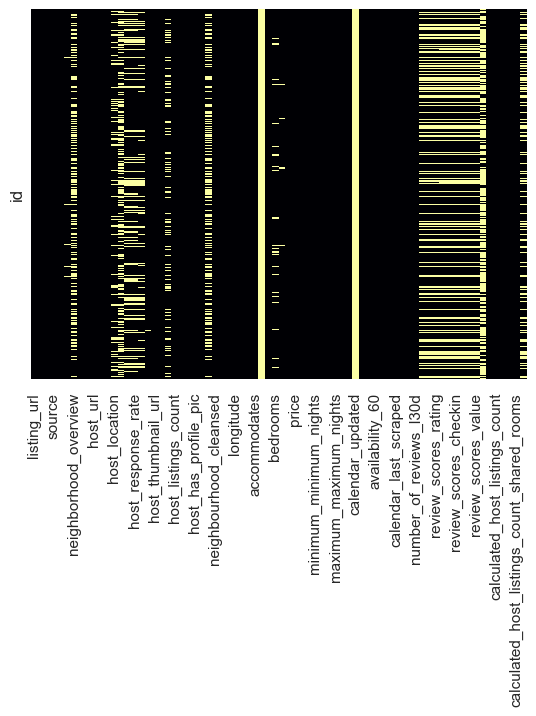

In [30]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='inferno')

In [25]:
umbral = 18  # Porcentaje límite de valores nulos

'''Obtener la lista de columnas a eliminar.
Utilizamos .index.tolist() para obtener una lista de los nombres de las columnas a eliminar.'''
columnas_eliminar = nulos_values_totales[nulos_values_totales['% nulos'] > umbral].index.tolist()

# Eliminar las columnas del DataFrame original
df1 = df.drop(columnas_eliminar, axis=1)

<Axes: ylabel='id'>

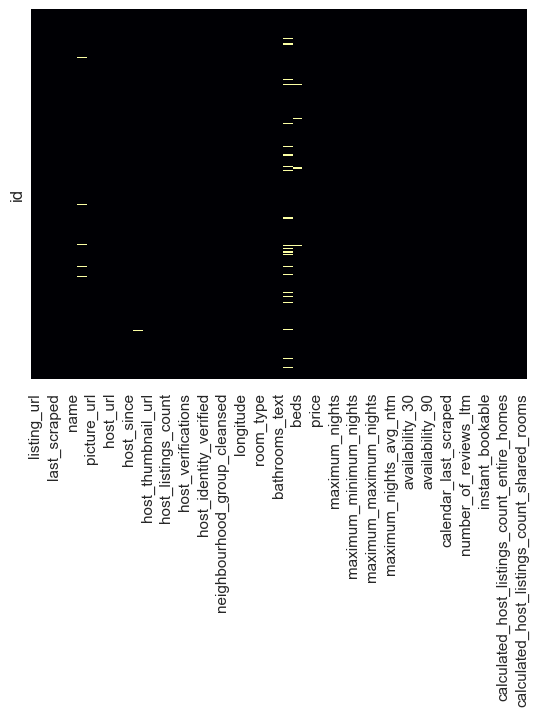

In [28]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='inferno')

In [37]:
nulos_values = df1.isnull().sum()
nulos_values_percentage = nulos_values/len(df1)*100 #Calculamos el % del los datos faltantes en cada columna
nulos_values_totales= nulos_values_percentage.sort_values(ascending = False) #Ordenamos de mayor a menor
nulos_values_totales = pd.DataFrame(nulos_values_totales,columns=["% nulos"])
nulos_values_totales[nulos_values_totales['% nulos'] > 0].sort_values(by="% nulos", ascending=False).T

,bedrooms,description,beds,host_is_superhost,bathrooms_text,maximum_nights_avg_ntm,maximum_minimum_nights,minimum_minimum_nights,minimum_nights_avg_ntm,maximum_maximum_nights,...,host_since,host_name,name,host_thumbnail_url,host_identity_verified,host_has_profile_pic,host_verifications,host_picture_url,host_listings_count,host_total_listings_count
% nulos,8.525123,1.766743,1.406327,0.374549,0.096582,0.011778,0.011778,0.011778,0.011778,0.011778,...,0.004711,0.004711,0.004711,0.004711,0.004711,0.004711,0.004711,0.004711,0.004711,0.004711


Analizamos de las columnas restantes con cuales nos quedamos y que hacemos con sus valores nulos:

# Bedrooms no la quiero para nada:
df1 = df1.drop('bedrooms', axis=1)


In [ ]:
# Elimino las que no quiero para nada:
df1 = df1.drop('bedrooms', 'description' 'beds','maximum_nights_avg_ntm','bathrooms_text' , axis=1)

# Me parece interesante saber si es superhost

'host_is_superhost'
# Me parece interesante saber si el minimo de noches para los que tienen mas de un alojamiento es de 30 dias sino incumplen con la ley porque solo pueden ofrecer estancias cortas los anfitriones que ofrecen su primera residencia. Si ofrecen su segunda o cualquier otra residencia minimo tienen que ofrecer 30 dias.
'maximum_minimum_nights'
